**--------------------------------------------------------------------------------------------------------------------------------------------------------------**


# ✅ Question 1 :
## Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use from keras.datasets import fashion_mnist for getting the fashion mnist dataset.

**--------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
!pip install wandb
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ed24s014 (ed24s014-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# ------------------- Imports -------------------
import numpy as np
import wandb
from keras.datasets import fashion_mnist

# ------------------- Load Fashion-MNIST Dataset -------------------
# Download and split the dataset into train and test sets
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

# ------------------- Define Constants -------------------
# Number of classes in the dataset
N_CLASSES = np.unique(trainy).shape[0]

# Class labels for the Fashion-MNIST dataset
IMG_LABELS = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# ------------------- Function to Get Sample Images and Log to W&B -------------------
def getSampleImages(nClass, imgLabels, X, y, nSamples):
    '''
    Logs sample images from each class to W&B

    Arguments:
      nClass     : Number of output classes
      imgLabels  : Class labels (as list of strings)
      X          : Image data (numpy array)
      y          : Labels (numpy array)
      nSamples   : Number of samples per class to log
    '''

    # Initialize list to collect samples per class
    sampleImgsX = [[] for _ in range(nClass)]

    # Collect samples
    for i in range(y.shape[0]):
        label = y[i]
        if len(sampleImgsX[label]) < nSamples:
            sampleImgsX[label].append(X[i])

    # Convert to wandb.Image with caption
    sampleImgsList = []
    for i in range(nClass):
        for j in range(nSamples):
            sampleImgsList.append(wandb.Image(sampleImgsX[i][j], caption=imgLabels[i]))

    # Shuffle and log to W&B
    np.random.shuffle(sampleImgsList)
    wandb.log({"example": sampleImgsList})


# ------------------- Question 1: W&B Logging -------------------
# Initialize wandb run
run = wandb.init(project="DL_A1_Q1", name="Q1_FashionMNIST_Sample_Images")

getSampleImages(N_CLASSES, IMG_LABELS, trainX, trainy, 1)

# Finish the run
run.finish()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


**--------------------------------------------------------------------------------------------------------------------------------------------------------------**



# ✅ Question 2 :
## Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes. Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

**Preprocessing code**

**--------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [ ]:
'''
This code defines classes for one-hot encoding labels, normalizing input features, and splitting data into training and validation sets,
which are essential steps in preprocessing for machine learning tasks. Each class handles a specific transformation to prepare data for
model training and evaluation.
'''
import numpy  as np

class OneHotEncoder:

    def __init__(self,x, y):
        self.y = y
        self.x = x
        #self.num_class = num_class
        self.onehot_encode()

    def onehot_encode(self):
        onehot = np.zeros((self.x.shape[0], 10))

        for i, j in zip(range(len(self.x)), self.y):
            onehot[i, j] = 1
        return onehot.T

class Normalize:

    def __init__(self, unprocessed_X):
        self.unprocessed_X = unprocessed_X
        self.Norm_reshape()

    def Norm_reshape(self):
        X_norm = np.reshape(self.unprocessed_X,(self.unprocessed_X.shape[0],784)).T/255
        X_norm= np.array(X_norm)

        return X_norm


class TrainValSplit:
  def __init__(self, X_train, y_train, Val_split_ratio = 0.9):
    self.X = X_train
    self.y = y_train
    self.vsr = Val_split_ratio

  def Apply_split(self):
    np.random.seed(0)

    i = np.random.permutation(len(self.X))
    split = int(self.X.shape[0] * (1 - self.vsr))

    train = i[:split]
    val = i[split:]

    train_X = self.X[train]
    val_X = self.X[val]

    train_y = self.y[train]
    val_y = self.y[val]

    return train_X , train_y, val_X, val_y

**Activation functions and their gradient calculation code**

In [ ]:
import numpy as np

class CalActivation:
    def __init__(self, m):
        self.m = m

# Sigmoid (for hidden layers)
class sigmoid(CalActivation):
    def use_sigmoid(self):
        return 1 / (1 + np.exp(-np.clip(self.m, -250, 250)))  # Clip inputs

    def sigmoid_d(self):
        sig = self.use_sigmoid()
        return sig * (1 - sig)


class relu(CalActivation):
    def use_relu(self):
        return np.maximum(0, self.m)

    def relu_d(self):
        return np.where(self.m > 0, 1, 0)

class Leakyrelu(CalActivation):
    def use_relu(self):
        return np.maximum(0, self.m)

    def relu_d(self):
        return np.where(self.m > 0, 1, 0.01)


class softmax(CalActivation):
    def use_softmax(self):
        shifted = self.m - np.max(self.m, axis=0, keepdims=True)
        exps = np.exp(shifted)
        return exps / np.sum(exps, axis=0, keepdims=True)


    def softmax_d(self):
        z=self.m - np.max(self.m,axis=0)
        soft=np.exp(z)/np.sum(np.exp(z),axis=0)
        return soft*(1-soft)

class tanh(CalActivation):
    def use_tanh(self):
        return np.tanh(self.m)  # Built-in is stable

    def tanh_d(self):
        return 1 - (self.use_tanh() ** 2)



# This function call different activation function
class apply_activation(CalActivation):

    def __init__(self, activation_function, m):
        super().__init__(m)
        self.activation_function = activation_function.lower()

    def do_activation(self):
        if self.activation_function == 'sigmoid':
            return sigmoid(self.m).use_sigmoid()
        elif self.activation_function == 'relu':
            return relu(self.m).use_relu()
        elif self.activation_function == 'lrelu':
            return Leakyrelu(self.m).use_relu()
        elif self.activation_function == 'tanh':
            return tanh(self.m).use_tanh()
        elif self.activation_function == 'softmax':
            return softmax(self.m).use_softmax()

    def do_activation_derivative(self):
        if self.activation_function == 'sigmoid':
            return sigmoid(self.m).sigmoid_d()
        elif self.activation_function == 'relu':
            return relu(self.m).relu_d()
        elif self.activation_function == 'lrelu':
            return Leakyrelu(self.m).relu_d()
        elif self.activation_function == 'tanh':
            return tanh(self.m).tanh_d()
        elif self.activation_function == 'softmax':
            return softmax(self.m).softmax_d()
        else:
           raise ValueError("Unknown activation function")


**Initilization of weights and biases code using Xavier / He / Random**

In [ ]:
import numpy as np

class Initilize:
    def __init__(self, layer_dimension, activation_function, y_train, method = "Xavier_U"):
        self.n = layer_dimension
        self.activation_fn = activation_function
        self.y = y_train
        self.Init_method = method

class InitializeWeights(Initilize):
    def __init__(self, ip_size, op_size, activation_function, batch_size, method):
        super().__init__([ip_size, op_size], activation_function, batch_size, method)  # Properly inherit Initilize attributes
        self.i_size = ip_size
        self.o_size = op_size
        self.Init_weights()


    def Init_weights(self):
        np.random.seed(0)

        if self.Init_method == "Xavier_N":
          np.random.seed(0)
          a = np.sqrt(1 / self.i_size)
          self.weight = np.random.randn(self.o_size,self.i_size)*a

        elif self.Init_method == "Xavier_U":
          np.random.seed(0)
          a = np.sqrt(6 / (self.o_size + self.i_size))
          self.weight = np.random.uniform((-a), a,( self.o_size,self.i_size))

        elif self.Init_method == "He_N":
          np.random.seed(0)
          a = np.sqrt(2 / self.i_size)
          self.weight = np.random.randn(self.o_size,self.i_size)*a

        elif self.Init_method == "He_U":
          np.random.seed(0)
          a = np.sqrt(6 / self.i_size)
          self.weight = np.random.uniform(-a, a, (self.o_size,self.i_size))

        elif self.Init_method == "Random":
          np.random.seed(0)
          self.weight = np.random.randn(self.o_size,self.i_size)*0.01
        else:
          raise ValueError(f"Unknown initialization method: {self.Init_method}")


        # Initialize biases and activations
        self.bias = np.zeros((self.o_size, 1))
        self.a = np.zeros((self.o_size, len(self.y[1])))
        self.h = np.zeros((self.o_size, len(self.y[1])))

        # Activation function and its derivative
        self.g = apply_activation(self.activation_fn, self.a).do_activation()
        self.d_g = apply_activation(self.activation_fn, self.a).do_activation_derivative()

        # Gradients
        self.d_a = np.zeros_like(self.a)
        self.d_h = np.zeros_like(self.h)
        self.d_w = np.zeros_like(self.weight)
        self.d_b = np.zeros_like(self.bias)
        self.Weight_updates = np.zeros_like(self.weight)
        self.bias_updates = np.zeros_like(self.bias)



class Weight_bias(Initilize):
    def __init__(self, layer_dimension, activation_function, y_train, method="Xavier_U"):
        super().__init__(layer_dimension, activation_function, y_train, method)
        self.network = []


    def Init_network(self):

        for i in range(1, len(self.n)):
          self.network.append(InitializeWeights( self.n[i-1], self.n[i], self.activation_fn[i-1], self.y, self.Init_method))

        return self.network


**Feedforward Code for Prediction**

In [ ]:
import numpy as np

class Pre_Feedforward:
    def __init__(self, inputs, w, b, activation_fn):
        self.ip = inputs
        self.w = w
        self.b = b
        self.activation_fn = activation_fn
        self.gamma = np.ones((w.shape[0], 1))  # Scale parameter for Batch Norm
        self.beta = np.zeros((w.shape[0], 1))  # Shift parameter for Batch Norm
        self.a, self.h = self.Preactivation_cal()

    def Preactivation_cal(self):
        A = np.dot(self.w, self.ip) + self.b

        # Activation Normalization (Per Sample Normalization)
        A_norm = (A - np.mean(A, axis=1, keepdims=True)) / (np.std(A, axis=1, keepdims=True) + 1e-8)

        # Batch Normalization (Learnable Parameters: gamma & beta)
        A_batch_norm = self.gamma * A_norm + self.beta  # Scale & Shift

        H = apply_activation(self.activation_fn, A_batch_norm).do_activation()
        return A_batch_norm, H  # Returning Batch Normalized Pre-Activation


class Feedforward:
    def __init__(self, X_train, activation_fn, method, network):
        self.input = X_train
        self.activation_fn = activation_fn
        self.method = method
        self.network = network

    def Forward_prop(self):
        L = len(self.network)

        for i in range(L):
            pre_layer = Pre_Feedforward(self.input, self.network[i].weight, self.network[i].bias, self.activation_fn[i])
            self.network[i].a = pre_layer.a
            self.network[i].h = pre_layer.h
            self.input = self.network[i].h  # Propagate activated values

        return self.network


In [ ]:
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_new= Normalize(X_train).Norm_reshape()
y_new =OneHotEncoder(X_train,y_train).onehot_encode()

 **Here is the answer of question 2 where we have to predict the output of 10 class in probability disturbution form**

In [ ]:
'''
Initialise the network with Xavier Uniform initilised weight and biases
'''

Initial_network = Weight_bias(layer_dimension = [784, 128, 64, 10],
                              activation_function = ['sigmoid','relu','softmax'],
                              y_train = y_new,
                              method = "Xavier_U").Init_network()

'''
Predicting the output of 10 class with Xavier Uniform initilised weight and biases
'''

Predict = Feedforward(X_train = X_new,
                     activation_fn= ['sigmoid','relu','softmax'],
                     method = "Xavier_U",
                     network= Initial_network).Forward_prop()


print(" Here is the prediction of output of 10 class in probability disturbution form \n with Xavier Uniform initilised weight and biases: \n\n", Predict[2].h)

 Here is the prediction of output of 10 class in probability disturbution form 
 with Xavier Uniform initilised weight and biases: 

 [[0.15131579 0.02254063 0.07011927 ... 0.02134032 0.1547177  0.27680912]
 [0.04236374 0.0366043  0.10287327 ... 0.09750509 0.02806686 0.03796533]
 [0.14732446 0.30968874 0.10342544 ... 0.27471801 0.07746666 0.01621352]
 ...
 [0.22240824 0.19012178 0.1045384  ... 0.014127   0.03969555 0.04926175]
 [0.01593975 0.23625835 0.06535765 ... 0.15377935 0.04608808 0.07835519]
 [0.2350658  0.03385474 0.10834192 ... 0.00426795 0.11168121 0.08030805]]


**--------------------------------------------------------------------------------------------------------------------------------------------------------------**


# ✅ Question 3 :
##Implement the backpropagation algorithm with support for the following optimisation functions

##sgd
##momentum based gradient descent
##nesterov accelerated gradient descent
##rmsprop
##adam
##nadam (Not required as aked)
##We will check the code for implementation and ease of use (e.g., how easy it is to add a new optimisation algorithm such as Eve). Note that the code should be flexible enough to work with different batch sizes.

**--------------------------------------------------------------------------------------------------------------------------------------------------------------**

**L2 / L1 Norm Regularization Code and their Gradient Calling functions :**

In [ ]:
import numpy as np

class Regularisation:
    def __init__(self, network, weight=0):
        self.network = network
        self.weight = weight

class L2_regularisation(Regularisation):
    def Apply_L2(self):
        """Returns L2 regularization loss for the given network."""
        L = len(self.network)
        res = 0
        for j in range(L):
            if np.isnan(self.network[j].weight).any():
                print(f"Warning: NaN detected in network weights at layer {j}")
                return 0  # Prevents NaN propagation
            res += 0.5 * np.sum(self.network[j].weight ** 2)
        return res

    def Apply_L2_grad(self, weight):
        """Returns L2 regularization gradient for the given weight matrix/tensor."""
        return 2 * weight

class L1_regularisation(Regularisation):
    def Apply_L1(self):
        """Returns L1 regularization loss for the given network."""
        L = len(self.network)
        res = 0
        for j in range(L):
            if np.isnan(self.network[j].weight).any():
                print(f"Warning: NaN detected in network weights at layer {j}")
                return 0  # Prevents NaN propagation
            res += (1 / 2) * np.sum(np.abs(self.network[j].weight))
        return res

    def Apply_L1_grad(self, weight):
        """Returns L1 regularization gradient for the given weight matrix/tensor."""
        return np.sign(weight)

class ApplyReg(Regularisation):
    def __init__(self, reg_function, network, weight=0):
        self.reg_function = reg_function
        super().__init__(network, weight)

    def do_reg(self):
        if self.reg_function == 'L2':
            return L2_regularisation(self.network).Apply_L2()
        if self.reg_function == 'L1':
            return L1_regularisation(self.network).Apply_L1()
        if self.reg_function == 'L2_d':
            return L2_regularisation(self.network).Apply_L2_grad(self.weight)  # Explicitly pass weight
        if self.reg_function == 'L1_d':
            return L1_regularisation(self.network).Apply_L1_grad(self.weight)  # Explicitly pass weight


**Overall Loss and Accuracy Calling functions code :**

In [ ]:
class CalculateAllLoss:
  def __init__(self, X_train, y_predicted,network, y_train, primary_loss, weight_decay=0, regularisation_fn=None):
    self.y_predicted = y_predicted
    self.y_true = y_train
    self.network = network
    self.X_train = X_train
    self.loss_value = primary_loss
    self.weight_decay = weight_decay
    self.regularisation_fn= regularisation_fn
    self.calc_accuracy_loss()


  def overall_loss(self):
    """
    Calculates the total loss of the network.

    This includes:
    - The primary loss (e.g., Cross-Entropy Loss)
    - Optional regularization (like L2 regularization)

    Parameters:
    - network: The neural network model.
    - Y_pred: The predicted output from the network.
    - Y_true: The actual labels (ground truth).
    - loss_fn: The loss function to be used (e.g., CrossEntropy_loss).
    - weight_decay: A coefficient for regularization (default is 0, meaning no regularization).
    - regularisation_fn: A function for computing the regularization term (optional).

    Returns:
    - Total loss value.
    """
    # Get network predictions self.y_prediction from model
    total_loss = self.loss_value  # Compute primary loss

    if self.weight_decay > 0 and self.regularisation_fn:
        regularized_val = ApplyReg(self.regularisation_fn, self.network).do_reg()
        total_loss += self.weight_decay * regularized_val # Add regularization term if applicable  # Compute total loss
    return total_loss




  def calc_accuracy_loss(self):
    """
    Computes the accuracy and loss for a given neural network.

    Parameters:
    - network: The neural network model.
    - X: Input data (features for prediction).
    - Y: Actual labels (ground truth values).
    - loss_fn: The loss function to be used.
    - weight_decay: Regularization strength (default is 0, meaning no regularization).
    - regularisation_fn: A function to compute the regularization term (optional).

    Returns:
    - accuracy: The percentage of correctly classified examples.
    - loss: The computed total loss.
    """

    total_loss = self.loss_value  # Compute primary loss

    if self.weight_decay > 0 and self.regularisation_fn:
        regularized_val = ApplyReg(self.regularisation_fn, self.network).do_reg()
        total_loss += self.weight_decay * regularized_val

    # Ensure dimensions match between input and labels
    assert self.X_train.shape[1] == self.y_true.shape[1], "Mismatch in batch size between inputs and labels"

    # Compute accuracy by comparing predicted vs actual labels
    batch_size = self.X_train.shape[1]  # Number of examples
    correct_predictions = np.sum(np.argmax(self.y_predicted, axis=0) == np.argmax(self.y_true, axis=0))

    accuracy = correct_predictions / batch_size  # Compute accuracy as a fraction

    return accuracy , total_loss



**All Loss functions and their Gradient Calling functions code :**

In [ ]:
import numpy as np

class CalLoss:
    def __init__(self, y, y_pred):
        self.y = y
        self.y_predicted = y_pred
        if y.shape != y_pred.shape:
            raise ValueError(f"Shape mismatch: y shape is {self.y.shape}, y_predicted shape is {self.y_predicted.shape}")

class CrossEntropy(CalLoss):
    def give_celoss(self):
        epsilon = 1e-8  # Small value to prevent log(0)
        return -np.mean(self.y * np.log(self.y_predicted + epsilon))

    def Give_cegrad(self):
        epsilon = 1e-8  # Prevent division by zero
        grad = -self.y / (self.y_predicted + epsilon)
        return grad

class SquaredError(CalLoss):
    def give_seloss(self):
        return np.mean((self.y - self.y_predicted) ** 2)

    def Give_segrad(self):
        grad = -2 * (self.y - self.y_predicted)
        return np.clip(grad, -1, 1)  # Clip to prevent exploding gradients

class callloss(CalLoss):
    def __init__(self, loss_function, y, y_pred):
        self.loss_function = loss_function.lower()
        super().__init__(y, y_pred)

    def give_loss(self):
        if self.loss_function == 'ce':
            return CrossEntropy(self.y, self.y_predicted).give_celoss()
        elif self.loss_function == 'se':
            return SquaredError(self.y, self.y_predicted).give_seloss()
        else:
            raise ValueError(f"Unknown loss function: {self.loss_function}")

    def give_gradloss(self):
        if self.loss_function == 'ce':
            return CrossEntropy(self.y, self.y_predicted).Give_cegrad()
        elif self.loss_function == 'se':
            return SquaredError(self.y, self.y_predicted).Give_segrad()
        else:
            raise ValueError(f"Unknown loss function: {self.loss_function}")


####Below we have the answers of question 3 : Proper Backprop code and along with that we ahve all 5 optimiser codes

**Backpropagation codes which returns the network :**

In [ ]:
from tqdm import tqdm
import math

class Backpropagation:

    def __init__(self, loss_function, X_train, y_train, y_pred, network, weight_decay, batch, batch_size, activation_fn):
        self.loss_function = loss_function
        self.X_train = X_train
        self.y_train = y_train
        self.y_predicted = y_pred
        self.network = network
        self.weight_decay = weight_decay
        self.batch = batch
        self.batch_size = batch_size
        self.activation_fn = activation_fn


    def backward_propagation(self):
      L = len(self.network)

      assert(self.y_train.shape[1] == self.y_predicted.shape[1])


      self.network[-1].d_a = callloss(self.loss_function,self.y_train, self.y_predicted).give_gradloss()
      # print("network -[-1].d_a : " , self.network[-1].d_a.shape)
      A_k = apply_activation(self.activation_fn[-1], self.network[-1].h).do_activation_derivative()
      # print("shape A_ k : " , A_k.shape)
      self.network[-1].d_h = self.network[-1].d_a * A_k
      # print("network -[-1].d_h : " , self.network[-1].d_a.shape)

      self.network[-1].d_w = self.network[-1].d_h @ self.network[-2].a.T  + self.weight_decay * self.network[-1].weight
      # print("network -[-1].d_w : " , self.network[-1].d_w.shape)
      d_b = -np.sum(self.network[-1].d_h, axis = 1)
      self.network[-1].d_b = d_b.reshape(-1 , 1)
      # print("network -[-1].d_b : " , self.network[-1].d_b.shape)



      for k in range(L-2,0,-1):
          # print(f"No of layers rotation {k}")

          self.network[k].d_h = self.network[k + 1].weight.T @ self.network[k + 1].d_a
          # print(f"shape self.network-{k}.d_h : " , self.network[k].d_h.shape)
          act_derv =  apply_activation(self.activation_fn[k], self.network[k].a)
          self.network[k].d_a = self.network[k].d_h * act_derv.do_activation_derivative()
          # print(f"shape self.network-{k}.d_a : " , self.network[k].d_a.shape)

          self.network[k].d_w = self.network[k].d_a @ self.network[k-1].h.T  + self.weight_decay * self.network[k].weight
          # print(f"shape self.network-{k}.d_w : " , self.network[k].d_w.shape)
          derv_bias = -np.sum(self.network[k].d_a, axis=1)
          self.network[k].d_b = derv_bias.reshape(-1 , 1)
          # print(f"shape self.network-{k}.d_b : " , self.network[k].d_b.shape)

      # print(f"shape self.network-{0}.d_a : " , self.network[0].d_a.shape)
      d_a = self.network[0].d_a[:, self.batch*self.batch_size : (self.batch+1)*self.batch_size]
      # print(f"shape self.network-{0}.d_a : " , d_a.shape)
      self.network[0].d_w = np.dot(d_a , self.X_train.T) + self.weight_decay * self.network[0].weight
      # print("network -[0].d_w : " , self.network[0].d_w.shape)
      self.network[0].d_b = np.sum(self.network[0].d_a, axis=1, keepdims = True)

      return self.network


**All 5 Optimisers ( SGD / Momentum / NAG / RMSProp / ADAM ) Calling functions :**

In [ ]:
from tqdm import tqdm
import math
import copy


class Optimizer:
  def __init__(self, loss_function, X_train, y_train, activation_fn, layers_dimensions ,method, batch_size, epochs,validX_train = None, validy_train = None,weight_decay = 0, eta = 0.01, beta = 0.9, beta2 = 0.999, regularization_fn = "L2",grad_reglr_fn = "L2_d"):
      self.loss_function = loss_function
      self.X_train = X_train
      self.y_train = y_train
      self.validX_train = validX_train
      self.validy_train = validy_train
      self.activation_fn = activation_fn
      self.method = method
      self.n = layers_dimensions
      self.batch_size = batch_size
      self.epochs = epochs
      self.weight_decay = weight_decay
      self.eta = eta
      self.epsilon =1e-10
      self.beta = beta
      self.beta2 = beta2
      self.regularization_fn = regularization_fn
      self.grad_reglr_fn = grad_reglr_fn
      self.batches_number = self.X_train.shape[1]//self.batch_size
      z = Weight_bias(self.n, self.activation_fn, self.y_train, self.method)
      self.init_network = z.Init_network()
      self.min_eta = 1e-4
      # wandb.init(project= "DA6401_Assignment_1" , name = "RMSProp with validation data of 1/3rd of 60k rows")


class SGD(Optimizer):

  def Gradient_descent(self):


    assert(self.X_train.shape[1] == self.y_train.shape[1])
    if self.validy_train is not None:
      assert(self.validX_train.shape[1] == self.validy_train.shape[1])
    L = len(self.n) - 1
    # Initialize variables neesed to keep track of loss
    self.eta_history = []
    self.loss_history = []
    self.training_history = []
    self.valid_loss_history = []
    self.validation_history = []
    overall_loss = 0
    accuracy = 0
    val_accuracy = 0
    val_overall_loss = 0
    self.batch = 0
    accuracy = 0
    val_accuracy = 0
    val_overall_loss = 0
    train_loss = 0
    val_loss = 0

    for epoch in tqdm(range(self.epochs)):

      for batch in range(self.batches_number):

        X_batch = self.X_train[:, batch*self.batch_size:(batch+1)*self.batch_size]
        self.X_batch = X_batch
        # print("X_batch shape : " , self.X_batch.shape)

        y_true_batch = self.y_train[:, batch*self.batch_size:(batch+1)*self.batch_size]
        # y_pred_batch = self.y_predicted[:, batch*self.batch_size:(batch+1)*self.batch_size]
        self.y_true_batch = y_true_batch
        fw_network = Feedforward(self.X_batch,self.activation_fn,self.method, self.init_network).Forward_prop()
        self.fw_network = fw_network
        self.y_predicted = self.fw_network[L-1].h
        self.y_pred_batch = self.y_predicted
        # self.y_pred_batch = self.y_predicted[:, batch*self.batch_size:(batch+1)*self.batch_size]
        # print("y_pred_batch shape : " , self.y_pred_batch.shape)
        # print("y_true_batch shape : " , self.y_true_batch.shape)
        assert(self.y_true_batch.shape[1] == self.y_pred_batch.shape[1])

        self.loss = callloss(self.loss_function, self.y_true_batch, self.y_pred_batch).give_loss()
        overall_loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.fw_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).overall_loss()
        self.loss_history.append(overall_loss)
        bp_network = Backpropagation(self.loss_function, self.X_batch, self.y_true_batch, self.y_pred_batch, self.fw_network, self.weight_decay, self.batch, self.batch_size, self.activation_fn ).backward_propagation()
        self.bp_network = bp_network

        if len(self.loss_history) > 5:  # Ensure we have enough data points
          recent_losses = self.loss_history[-5:]
          loss_std = np.std(recent_losses)  # Compute standard deviation of recent losses

          if self.loss_history[-1] > self.loss_history[-2]:
              self.eta = max(self.eta * (0.9 if loss_std < 0.01 else 0.8), self.min_eta)

        self.eta_history.append(self.eta)

        for j in range(L):
          self.fw_network[j].weight -= self.eta * self.bp_network[j].d_w
          self.fw_network[j].bias -= self.eta * self.bp_network[j].d_b

        acc, loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.init_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss()
        accuracy = round(acc , 4)
        train_loss = round(loss , 4)
        self.training_history.append(CalculateAllLoss(self.X_batch, self.y_pred_batch, self.init_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss())


        if self.validX_train is not None:
          network = Feedforward(self.validX_train,self.activation_fn,self.method, self.init_network).Forward_prop()
          self.network = network
          self.valy_predicted = self.network[L-1].h
          val_acc, v_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss()
          val_accuracy = round(val_acc , 4)
          val_loss = round(v_loss , 4)
          val_overall_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).overall_loss()
          self.validation_history.append(CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss())


        # wandb.log({'epoch': self.epochs,  # Use current epoch, not total epochs
        #             'validation_accuracy': val_accuracy if self.validX_train is not None else 0,
        #             'accuracy': accuracy,
        #             'validation_loss': val_loss if self.validX_train is not None else 0,
        #             'loss': train_loss
        #         })
      print(f"   Epochs no: {(epoch+1)}  |  Train acc: {accuracy}  |  val acc: {val_accuracy}  |  Train Loss: {train_loss} |  Val Loss : {val_loss}")

    return self.init_network, train_loss, accuracy, val_accuracy, val_loss



class MGD(Optimizer):

  def momentum_GD(self):

    assert(self.X_train.shape[1] == self.y_train.shape[1])
    if self.validy_train is not None:
      assert(self.validX_train.shape[1] == self.validy_train.shape[1])
    L = len(self.n) - 1
    # Initialize variables neesed to keep track of loss
    self.eta_history = []
    self.loss_history = []
    self.training_history = []
    self.valid_loss_history = []
    self.validation_history = []
    overall_loss = 0
    self.batch = 0
    accuracy = 0
    val_accuracy = 0
    val_overall_loss = 0
    train_loss = 0
    val_loss = 0

    u_w = [np.zeros_like(self.init_network[k].weight) for k in range(L)]
    u_b = [np.zeros_like(self.init_network[k].bias) for k in range(L)]

    for epoch in tqdm(range(self.epochs)):

      for batch in range(self.batches_number):

        X_batch = self.X_train[:, batch*self.batch_size:(batch+1)*self.batch_size]
        self.X_batch = X_batch
        # print("X_batch shape : " , self.X_batch.shape)

        y_true_batch = self.y_train[:, batch*self.batch_size:(batch+1)*self.batch_size]
        # y_pred_batch = self.y_predicted[:, batch*self.batch_size:(batch+1)*self.batch_size]
        self.y_true_batch = y_true_batch
        fw_network = Feedforward(self.X_batch,self.activation_fn,self.method, self.init_network).Forward_prop()
        self.fw_network = fw_network
        self.y_predicted = self.fw_network[L-1].h
        self.y_pred_batch = self.y_predicted
        # self.y_pred_batch = self.y_predicted[:, batch*self.batch_size:(batch+1)*self.batch_size]
        # print("y_pred_batch shape : " , self.y_pred_batch.shape)
        # print("y_true_batch shape : " , self.y_true_batch.shape)
        assert(self.y_true_batch.shape[1] == self.y_pred_batch.shape[1])

        self.loss = callloss(self.loss_function, self.y_true_batch, self.y_pred_batch).give_loss()
        overall_loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.fw_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).overall_loss()
        self.loss_history.append(overall_loss)
        bp_network = Backpropagation(self.loss_function, self.X_batch, self.y_true_batch, self.y_pred_batch, self.fw_network, self.weight_decay, self.batch, self.batch_size, self.activation_fn ).backward_propagation()
        self.bp_network = bp_network

        if len(self.loss_history) > 5:  # Ensure we have enough data points
          recent_losses = self.loss_history[-5:]
          loss_std = np.std(recent_losses)  # Compute standard deviation of recent losses

          if self.loss_history[-1] > self.loss_history[-2]:
              self.eta = max(self.eta * (0.9 if loss_std < 0.01 else 0.8), self.min_eta)

        self.eta_history.append(self.eta)
        # self.beta = min(1 - 2 ** (-1 - math.log((self.calls / 250.0) + 1, 2)), self.beta)

        for j in range(L):
          u_w[j] = u_w[j] * self.beta + self.bp_network[j].d_w * self.eta
          u_b[j] = u_b[j] * self.beta + self.bp_network[j].d_b * self.eta

          self.fw_network[j].weight -= u_w[j]
          self.fw_network[j].bias -= u_b[j]

        acc, loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.init_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss()
        accuracy = round(acc , 4)
        train_loss = round(loss , 4)
        self.training_history.append(CalculateAllLoss(self.X_batch, self.y_pred_batch, self.init_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss())


        if self.validX_train is not None:
          network = Feedforward(self.validX_train,self.activation_fn,self.method, self.init_network).Forward_prop()
          self.network = network
          self.valy_predicted = self.network[L-1].h
          val_acc, v_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss()
          val_accuracy = round(val_acc , 4)
          val_loss = round(v_loss , 4)
          val_overall_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).overall_loss()
          self.validation_history.append(CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss())


        # wandb.log({'epoch': self.epochs,  # Use current epoch, not total epochs
        #             'validation_accuracy': val_accuracy if self.validX_train is not None else 0,
        #             'accuracy': accuracy,
        #             'validation_loss': val_loss if self.validX_train is not None else 0,
        #             'loss': train_loss
        #         })
      print(f"   Epochs no: {(epoch+1)}  |  Train acc: {accuracy}  |  val acc: {val_accuracy}  |  Train Loss: {train_loss} |  Val Loss : {val_loss}")

    return self.init_network, train_loss, accuracy, val_accuracy, val_loss




class NAG(Optimizer):

  def Nesterov_AGD(self):

    assert(self.X_train.shape[1] == self.y_train.shape[1])
    if self.validy_train is not None:
      assert(self.validX_train.shape[1] == self.validy_train.shape[1])
    L = len(self.n) - 1
    # Initialize variables neesed to keep track of loss
    self.eta_history = []
    self.loss_history = []
    self.training_history = []
    self.valid_loss_history = []
    self.validation_history = []
    overall_loss = 0
    self.batch = 0
    accuracy = 0
    val_accuracy = 0
    val_overall_loss = 0
    train_loss = 0
    val_loss = 0
    u_w = [np.zeros_like(self.init_network[k].weight) for k in range(L)]
    u_b = [np.zeros_like(self.init_network[k].bias) for k in range(L)]

    lookleap_network = self.init_network[:]

    for epoch in tqdm(range(self.epochs)):

      for batch in range(self.batches_number):

        X_batch = self.X_train[:, batch*self.batch_size:(batch+1)*self.batch_size]
        self.X_batch = X_batch
        # print("X_batch shape : " , self.X_batch.shape)

        y_true_batch = self.y_train[:, batch*self.batch_size:(batch+1)*self.batch_size]
        # y_pred_batch = self.y_predicted[:, batch*self.batch_size:(batch+1)*self.batch_size]
        self.y_true_batch = y_true_batch
        fw_network = Feedforward(self.X_batch,self.activation_fn,self.method, self.init_network).Forward_prop()
        self.fw_network = fw_network
        self.y_predicted = self.fw_network[L-1].h
        self.y_pred_batch = self.y_predicted
        # self.y_pred_batch = self.y_predicted[:, batch*self.batch_size:(batch+1)*self.batch_size]
        # print("y_pred_batch shape : " , self.y_pred_batch.shape)
        # print("y_true_batch shape : " , self.y_true_batch.shape)
        assert(self.y_true_batch.shape[1] == self.y_pred_batch.shape[1])

        self.loss = callloss(self.loss_function, self.y_true_batch, self.y_pred_batch).give_loss()
        overall_loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.fw_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).overall_loss()
        self.loss_history.append(overall_loss)
        bp_network = Backpropagation(self.loss_function, self.X_batch, self.y_true_batch, self.y_pred_batch, self.fw_network, self.weight_decay, self.batch, self.batch_size, self.activation_fn ).backward_propagation()
        self.bp_network = bp_network

        if len(self.loss_history) > 5:  # Ensure we have enough data points
          recent_losses = self.loss_history[-5:]
          loss_std = np.std(recent_losses)  # Compute standard deviation of recent losses

          if self.loss_history[-1] > self.loss_history[-2]:
              self.eta = max(self.eta * (0.9 if loss_std < 0.01 else 0.8), self.min_eta)

        self.eta_history.append(self.eta)

        for j in range(L):
          u_w[j] = u_w[j] * self.beta + self.bp_network[j].d_w * self.eta
          u_b[j] = u_b[j] * self.beta + self.bp_network[j].d_b * self.eta

          self.fw_network[j].weight -= u_w[j]
          self.fw_network[j].bias -= u_b[j]

          lookleap_network[j].weight -= (self.eta * self.bp_network[j].d_w + self.beta * u_w[j])
          lookleap_network[j].bias -= (self.eta * self.bp_network[j].d_b + self.beta * u_b[j])

        acc, loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.init_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss()
        accuracy = round(acc , 4)
        train_loss = round(loss , 4)
        self.training_history.append(CalculateAllLoss(self.X_batch, self.y_pred_batch, self.init_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss())


        if self.validX_train is not None:
          network = Feedforward(self.validX_train,self.activation_fn,self.method, self.init_network).Forward_prop()
          self.network = network
          self.valy_predicted = self.network[L-1].h
          val_acc, v_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss()
          val_accuracy = round(val_acc , 4)
          val_loss = round(v_loss , 4)
          val_overall_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).overall_loss()
          self.validation_history.append(CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss())


        # wandb.log({'epoch': self.epochs,  # Use current epoch, not total epochs
        #             'validation_accuracy': val_accuracy if self.validX_train is not None else 0,
        #             'accuracy': accuracy,
        #             'validation_loss': val_loss if self.validX_train is not None else 0,
        #             'loss': train_loss
        #         })
      print(f"   Epochs no: {(epoch+1)}  |  Train acc: {accuracy}  |  val acc: {val_accuracy}  |  Train Loss: {train_loss} |  Val Loss : {val_loss}")

    return self.init_network, train_loss, accuracy, val_accuracy, val_loss



class RMSProp(Optimizer):

  def rms_GD(self):

    assert(self.X_train.shape[1] == self.y_train.shape[1])
    if self.validy_train is not None:
      assert(self.validX_train.shape[1] == self.validy_train.shape[1])
    L = len(self.n) - 1
    # Initialize variables neesed to keep track of loss
    self.eta_history = []
    self.loss_history = []
    self.training_history = []
    self.valid_loss_history = []
    self.validation_history = []
    overall_loss = 0
    self.batch = 0
    accuracy = 0
    val_accuracy = 0
    val_overall_loss = 0
    train_loss = 0
    val_loss = 0
    u_w = [np.zeros_like(self.init_network[k].weight) for k in range(L)]
    u_b = [np.zeros_like(self.init_network[k].bias) for k in range(L)]

    for epoch in tqdm(range(self.epochs)):

      for batch in range(self.batches_number):

        X_batch = self.X_train[:, batch*self.batch_size:(batch+1)*self.batch_size]
        self.X_batch = X_batch
        # print("X_batch shape : " , self.X_batch.shape)

        y_true_batch = self.y_train[:, batch*self.batch_size:(batch+1)*self.batch_size]
        # y_pred_batch = self.y_predicted[:, batch*self.batch_size:(batch+1)*self.batch_size]
        self.y_true_batch = y_true_batch
        fw_network = Feedforward(self.X_batch,self.activation_fn,self.method, self.init_network).Forward_prop()
        self.fw_network = fw_network
        self.y_predicted = self.fw_network[L-1].h
        self.y_pred_batch = self.y_predicted
        # self.y_pred_batch = self.y_predicted[:, batch*self.batch_size:(batch+1)*self.batch_size]
        # print("y_pred_batch shape : " , self.y_pred_batch.shape)
        # print("y_true_batch shape : " , self.y_true_batch.shape)
        assert(self.y_true_batch.shape[1] == self.y_pred_batch.shape[1])

        self.loss = callloss(self.loss_function, self.y_true_batch, self.y_pred_batch).give_loss()
        overall_loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.fw_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).overall_loss()
        self.loss_history.append(overall_loss)
        bp_network = Backpropagation(self.loss_function, self.X_batch, self.y_true_batch, self.y_pred_batch, self.fw_network, self.weight_decay, self.batch, self.batch_size, self.activation_fn ).backward_propagation()
        self.bp_network = bp_network

        if len(self.loss_history) > 5:  # Ensure we have enough data points
          recent_losses = self.loss_history[-5:]
          loss_std = np.std(recent_losses)  # Compute standard deviation of recent losses

          if self.loss_history[-1] > self.loss_history[-2]:
              self.eta = max(self.eta * (0.9 if loss_std < 0.01 else 0.8), self.min_eta)

        self.eta_history.append(self.eta)

        for j in range(L):
          u_w[j] = u_w[j] * self.beta +  (1  - self.beta) * (self.bp_network[j].d_w)**2
          u_b[j] = u_b[j] * self.beta +  (1  - self.beta) * (self.bp_network[j].d_b)**2

          self.fw_network[j].weight -= (self.eta / np.sqrt(u_w[j] + self.epsilon)) * self.bp_network[j].d_w
          self.fw_network[j].bias -= (self.eta / np.sqrt(u_b[j] + self.epsilon)) * self.bp_network[j].d_b

        acc, loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.init_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss()
        accuracy = round(acc , 4)
        train_loss = round(loss , 4)
        self.training_history.append(CalculateAllLoss(self.X_batch, self.y_pred_batch, self.init_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss())

        if self.validX_train is not None:
          network = Feedforward(self.validX_train,self.activation_fn,self.method, self.init_network).Forward_prop()
          self.network = network
          self.valy_predicted = self.network[L-1].h
          val_acc, v_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss()
          val_accuracy = round(val_acc , 4)
          val_loss = round(v_loss , 4)
          val_overall_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).overall_loss()
          self.validation_history.append(CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss())


        # wandb.log({'epoch': self.epochs,  # Use current epoch, not total epochs
        #             'validation_accuracy': val_accuracy if self.validX_train is not None else 0,
        #             'accuracy': accuracy,
        #             'validation_loss': val_loss if self.validX_train is not None else 0,
        #             'loss': train_loss
        #         })
      print(f"   Epochs no: {(epoch+1)}  |  Train acc: {accuracy}  |  val acc: {val_accuracy}  |  Train Loss: {train_loss} |  Val Loss : {val_loss}")

    return self.init_network, train_loss, accuracy, val_accuracy, val_loss


class ADAM(Optimizer):

  def adam_GD(self):

    assert(self.X_train.shape[1] == self.y_train.shape[1])
    if self.validy_train is not None:
      assert(self.validX_train.shape[1] == self.validy_train.shape[1])
    L = len(self.n) - 1
    # Initialize variables neesed to keep track of loss
    self.eta_history = []
    self.loss_history = []
    self.training_history = []
    self.valid_loss_history = []
    self.validation_history = []
    self.f_network = []
    overall_loss = 0
    self.batch = 0
    accuracy = 0
    val_accuracy = 0
    val_overall_loss = 0
    train_loss = 0
    val_loss = 0

    i = 0
    u_w = [np.zeros_like(self.init_network[k].weight) for k in range(L)]
    u_b = [np.zeros_like(self.init_network[k].bias) for k in range(L)]
    v_w = [np.zeros_like(self.init_network[k].weight) for k in range(L)]
    v_b = [np.zeros_like(self.init_network[k].bias) for k in range(L)]

    for epoch in tqdm(range(self.epochs)):


      for batch in range(self.batches_number):


        X_batch = self.X_train[:, batch*self.batch_size:(batch+1)*self.batch_size]
        self.X_batch = X_batch
        # print("X_batch shape : " , self.X_batch.shape)

        y_true_batch = self.y_train[:, batch*self.batch_size:(batch+1)*self.batch_size]
        # y_pred_batch = self.y_predicted[:, batch*self.batch_size:(batch+1)*self.batch_size]
        self.y_true_batch = y_true_batch
        fw_network = Feedforward(self.X_batch,self.activation_fn,self.method, self.init_network).Forward_prop()
        self.fw_network = fw_network
        self.y_predicted = self.fw_network[L-1].h
        self.y_pred_batch = self.y_predicted
        # self.y_pred_batch = self.y_predicted[:, batch*self.batch_size:(batch+1)*self.batch_size]
        # print("y_pred_batch shape : " , self.y_pred_batch.shape)
        # print("y_true_batch shape : " , self.y_true_batch.shape)
        assert(self.y_true_batch.shape[1] == self.y_pred_batch.shape[1])

        self.loss = callloss(self.loss_function, self.y_true_batch, self.y_pred_batch).give_loss()
        overall_loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.fw_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).overall_loss()
        self.loss_history.append(overall_loss)
        bp_network = Backpropagation(self.loss_function, self.X_batch, self.y_true_batch, self.y_pred_batch, self.fw_network, self.weight_decay, self.batch, self.batch_size, self.activation_fn ).backward_propagation()
        self.bp_network = bp_network

        if len(self.loss_history) > 5:  # Ensure we have enough data points
          recent_losses = self.loss_history[-5:]
          loss_std = np.std(recent_losses)  # Compute standard deviation of recent losses

          if self.loss_history[-1] > self.loss_history[-2]:
              self.eta = max(self.eta * (0.9 if loss_std < 0.01 else 0.8), self.min_eta)

        self.eta_history.append(self.eta)

        for j in range(L):
          u_w[j] = u_w[j] * self.beta +  (1  - self.beta) * (self.bp_network[j].d_w)
          u_b[j] = u_b[j] * self.beta +  (1  - self.beta) * (self.bp_network[j].d_b)
          v_w[j] = v_w[j] * self.beta2 +  (1  - self.beta2) * (self.bp_network[j].d_w)**2
          v_b[j] = v_b[j] * self.beta2 +  (1  - self.beta2) * (self.bp_network[j].d_b)**2

          u_w_pred = u_w[j] / (1 - np.power(self.beta , i+1))
          u_b_pred = u_b[j] / (1 - np.power(self.beta , i+1))
          v_w_pred = v_w[j] / (1 - np.power(self.beta2 , i+1))
          v_b_pred = v_b[j] / (1 - np.power(self.beta2 , i+1))

          self.fw_network[j].weight -= (self.eta / (np.sqrt(v_w_pred) + self.epsilon)) * u_w_pred
          self.fw_network[j].bias -= (self.eta / (np.sqrt(v_b_pred) + self.epsilon)) * u_b_pred

        self.init_network = self.fw_network

        acc, loss = CalculateAllLoss(self.X_batch, self.y_pred_batch, self.init_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss()
        accuracy = round(acc , 5)
        train_loss = round(loss , 5)
        self.training_history.append(CalculateAllLoss(self.X_batch, self.y_pred_batch, self.init_network, self.y_true_batch, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss())
        i+=1

        if self.validX_train is not None:
          network = Feedforward(self.validX_train,self.activation_fn,self.method, self.init_network).Forward_prop()
          self.network = network
          self.valy_predicted = self.network[L-1].h
          val_acc, v_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss()
          val_accuracy = round(val_acc , 5)
          val_loss = round(v_loss , 5)
          val_overall_loss = CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).overall_loss()
          self.validation_history.append(CalculateAllLoss(self.validX_train, self.valy_predicted, self.init_network, self.validy_train, self.loss, self.weight_decay, self.regularization_fn).calc_accuracy_loss())


        # wandb.log({'epoch': self.epochs,  # Use current epoch, not total epochs
        #             'validation_accuracy': val_accuracy if self.validX_train is not None else 0,
        #             'accuracy': accuracy,
        #             'validation_loss': val_loss if self.validX_train is not None else 0,
        #             'loss': train_loss
        #         })
      print(f"   Epochs no: {(epoch+1)}  |  Train acc: {accuracy}  |  val acc: {val_accuracy}  |  Train Loss: {train_loss} |  Val Loss : {val_loss}")

    return self.init_network, train_loss, accuracy, val_accuracy, val_loss


class GiveOptimizers(Optimizer):
    def __init__(self, optimization_fn, loss_function, X_train, y_train, activation_fn, layers_dimensions ,method, batch_size, epochs,  validX_train , validy_train ,weight_decay = 0, eta = 0.01, beta = 0.9, beta2 = 0.999, regularization_fn = "L2",grad_reglr_fn = "L2_d"):
      self.optimization_function = optimization_fn.lower()
      super().__init__( loss_function, X_train, y_train, activation_fn, layers_dimensions ,method, batch_size, epochs, validX_train, validy_train ,weight_decay = 0, eta = 0.01, beta = 0.9, beta2 = 0.999, regularization_fn = "L2",grad_reglr_fn = "L2_d" )

    def apply_optimization(self):
      if self.optimization_function == 'sgd':
          return SGD(self.loss_function, self.X_train, self.y_train, self.activation_fn, self.n, self.method, self.batch_size, self.epochs,  self.validX_train, self.validy_train, self.weight_decay,self.eta, self.beta, self.beta2, self.regularization_fn, self.grad_reglr_fn).Gradient_descent()
      elif self.optimization_function == 'momentum':
          return MGD(self.loss_function, self.X_train, self.y_train, self.activation_fn, self.n, self.method, self.batch_size, self.epochs, self.validX_train, self.validy_train, self.weight_decay,self.eta, self.beta, self.beta2, self.regularization_fn, self.grad_reglr_fn).momentum_GD()
      elif self.optimization_function == 'nag':
          return NAG(self.loss_function, self.X_train, self.y_train, self.activation_fn, self.n, self.method, self.batch_size, self.epochs, self.validX_train, self.validy_train, self.weight_decay,self.eta, self.beta, self.beta2, self.regularization_fn, self.grad_reglr_fn).Nesterov_AGD()
      elif self.optimization_function == 'rmsp':
          return RMSProp(self.loss_function, self.X_train, self.y_train, self.activation_fn, self.n, self.method, self.batch_size, self.epochs, self.validX_train, self.validy_train, self.weight_decay,self.eta, self.beta, self.beta2, self.regularization_fn, self.grad_reglr_fn).rms_GD()
      elif self.optimization_function == 'adam':
          return ADAM(self.loss_function, self.X_train, self.y_train, self.activation_fn, self.n, self.method, self.batch_size, self.epochs, self.validX_train, self.validy_train, self.weight_decay,self.eta, self.beta, self.beta2, self.regularization_fn, self.grad_reglr_fn).adam_GD()

In [ ]:
class NeuralNetwork:
    def __init__(self, loss_function, X_train, y_train, activation_fn, optimization_fn,
                 layers_dimensions, method, batch_size, epochs, val_ratio,
                 weight_decay=0, eta=0.01, beta=0.9, beta2=0.999,
                 regularization_fn="L2", grad_reglr_fn="L2_d"):

        self.loss_function = loss_function
        self.X_train = X_train
        self.y_train = y_train
        self.activation_fn = activation_fn
        self.method = method
        self.n = layers_dimensions
        self.optimization_fn = optimization_fn
        self.batch_size = batch_size
        self.epochs = epochs
        self.val_ratio = val_ratio
        self.weight_decay = weight_decay
        self.eta = eta
        self.epsilon = 1e-10
        self.beta = beta
        self.beta2 = beta2
        self.regularization_fn = regularization_fn
        self.grad_reglr_fn = grad_reglr_fn
        self.batches_number = max(1, self.X_train.shape[1] // self.batch_size)


        # Splitting data
        X_split, y_split, valX_split, valy_split = TrainValSplit(self.X_train, self.y_train, self.val_ratio).Apply_split()

        # Normalization & Encoding
        self.X_norm = Normalize(X_split).Norm_reshape()
        self.y_norm = OneHotEncoder(X_split, y_split).onehot_encode()
        self.valX_norm = Normalize(valX_split).Norm_reshape()
        self.valy_norm = OneHotEncoder(valX_split, valy_split).onehot_encode()

        # Ensure correct dimensions
        if self.X_norm.shape[1] != self.y_norm.shape[1]:
            raise ValueError(f"Mismatch in training data shapes: {self.X_norm.shape} vs {self.y_norm.shape}")

        if self.valy_norm is not None and self.valX_norm.shape[1] != self.valy_norm.shape[1]:
            raise ValueError(f"Mismatch in validation data shapes: {self.valX_norm.shape} vs {self.valy_norm.shape}")

    def trainNN(self):
        NNModel = GiveOptimizers(
            self.optimization_fn, self.loss_function, self.X_norm, self.y_norm,
            self.activation_fn, self.n, self.method, self.batch_size, self.epochs,
            self.valX_norm, self.valy_norm, self.weight_decay, self.eta,
            self.beta, self.beta2, self.regularization_fn, self.grad_reglr_fn
        ).apply_optimization()

        if NNModel is None:
            raise ValueError("Model initialization failed. `GiveOptimizers.apply_optimization()` returned None.")

        if not isinstance(NNModel, (list, tuple)) or len(NNModel) < 5:
            raise ValueError(f"Unexpected NNModel structure: {type(NNModel)} with length {len(NNModel)}")

        final_network = NNModel[0]
        overall_loss = NNModel[1]
        accuracy = NNModel[2]
        val_loss = NNModel[3]
        val_acc = NNModel[4]

        return final_network, overall_loss, accuracy, val_loss, val_acc


In [ ]:
import wandb
class NNTrainer:
    def __init__(self, X_train, y_train, num_hidden_layers, hidden_layer_sizes, activation_fns,
                 optimizer, batch_size, learning_rate, epochs, weight_init, loss_fn,
                 reg_type="L2", weight_decay=0, val_ratio=0.2, method="default",
                 beta=0.9, beta2=0.999,
                 X_test=None, y_test=None):
        """
        Wrapper class to simplify training a NeuralNetwork model.
        Now it dynamically constructs the layer dimensions and activation functions.
        """
        self.X_train = X_train
        self.y_train = y_train
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation_fns = activation_fns
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weight_init = weight_init
        self.loss_fn = loss_fn
        self.reg_type = reg_type
        self.weight_decay = weight_decay
        self.val_ratio = val_ratio
        self.method = method
        self.beta = beta
        self.beta2 = beta2
        self.X_test = X_test
        self.y_test = y_test

        # Automatically construct layer dimensions
        self.layers_dimensions = self._construct_layers()
        self.activation_fn = self._construct_activations()

        # Data Preprocessing
        self._prepare_data()

    def _construct_layers(self):
        """Constructs layer dimensions based on the number of hidden layers and their sizes."""
        input_size = 784  # Fashion-MNIST input size
        output_size = 10   # Number of classes in Fashion-MNIST
        return [input_size] + self.hidden_layer_sizes[:self.num_hidden_layers] + [output_size]

    def _construct_activations(self):
        """Constructs activation functions for each hidden layer, ending with softmax for classification."""
        return self.activation_fns[:self.num_hidden_layers] + ["softmax"]


    def _prepare_data(self):
        """Splits and normalizes train/validation/test data."""
        self.X_train, self.y_train, self.X_val, self.y_val = TrainValSplit(
            self.X_train, self.y_train, self.val_ratio).Apply_split()

        self.X_norm = Normalize(self.X_train).Norm_reshape()
        self.y_norm = OneHotEncoder(self.X_train, self.y_train).onehot_encode()
        self.X_val_norm = Normalize(self.X_val).Norm_reshape()
        self.y_val_norm = OneHotEncoder(self.X_val, self.y_val).onehot_encode()

        if self.X_test is not None and self.y_test is not None:
            self.X_test_norm = Normalize(self.X_test).Norm_reshape()
            self.y_test_norm = OneHotEncoder(self.X_test, self.y_test).onehot_encode()
        else:
            self.X_test_norm = None
            self.y_test_norm = None

    def train(self):
        """Trains the neural network and returns train/val/test metrics."""
        model = NeuralNetwork(
            loss_function=self.loss_fn,
            X_train=self.X_train, y_train=self.y_train,
            activation_fn=self.activation_fn,
            optimization_fn=self.optimizer,
            layers_dimensions=self.layers_dimensions,
            method=self.method, batch_size=self.batch_size,
            epochs=self.epochs, val_ratio=self.val_ratio,
            weight_decay=self.weight_decay, eta=self.learning_rate,
            beta=self.beta, beta2=self.beta2,
            regularization_fn=self.reg_type,
            grad_reglr_fn=f"{self.reg_type}_d",
        )

        # Train the model
        final_network, overall_loss, train_accuracy, val_loss, val_accuracy = model.trainNN()

        # If test data is provided, evaluate on test set
        test_loss, test_accuracy = None, None
        if self.X_test_norm is not None and self.y_test_norm is not None:
            y_test_predicted = Feedforward(self.X_test_norm, self.activation_fn, self.method, final_network).Forward_prop()
            y_test_pred = np.array(y_test_predicted[-1].h)
            loss = callloss(self.loss_fn, self.y_test_norm, y_test_pred).give_loss()
            test_loss_obj = CalculateAllLoss(X_train=self.X_test_norm, y_predicted=y_test_pred, network=final_network,
                                             y_train=self.y_test_norm, primary_loss=loss, weight_decay=self.weight_decay,
                                             regularisation_fn=self.reg_type)
            test_accuracy, test_loss = test_loss_obj.calc_accuracy_loss()

        return overall_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy


**Below the trainer function is used to run the whole model properly also as asked in the the Question-3 , the model is flexible enough to take varity of hyperparameters which canbe easily changed.**

In [ ]:
from pickle import FALSE
trainer = NNTrainer(
    X_train=X_train,
    y_train=y_train,
    num_hidden_layers=5,  # Specify the number of hidden layers
    hidden_layer_sizes=[128, 64, 32],  # Specify possible sizes per hidden layer
    activation_fns=["tanh", "sigmoid", "tanh"],  # Specify possible activations
    optimizer="adam",
    batch_size=10000,
    learning_rate=0.01,
    epochs=5,
    weight_init="Xavier_U",
    loss_fn="ce",
    reg_type="L2",
    weight_decay=0.0005,
    val_ratio=0.1,
    method="Xavier_U",
    beta=0.9,
    beta2=0.999,
    X_test=X_test,
    y_test=y_test
)

train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = trainer.train()


 20%|██        | 1/5 [00:02<00:09,  2.32s/it]

   Epochs no: 1  |  Train acc: 0.6086  |  val acc: 0.63444  |  Train Loss: 0.13577 |  Val Loss : 0.13577


 40%|████      | 2/5 [00:06<00:09,  3.27s/it]

   Epochs no: 2  |  Train acc: 0.6699  |  val acc: 0.66259  |  Train Loss: 0.12993 |  Val Loss : 0.12993


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

   Epochs no: 3  |  Train acc: 0.6628  |  val acc: 0.66574  |  Train Loss: 0.13456 |  Val Loss : 0.13456


 80%|████████  | 4/5 [00:10<00:02,  2.44s/it]

   Epochs no: 4  |  Train acc: 0.6636  |  val acc: 0.66444  |  Train Loss: 0.13843 |  Val Loss : 0.13843


100%|██████████| 5/5 [00:12<00:00,  2.47s/it]

   Epochs no: 5  |  Train acc: 0.6636  |  val acc: 0.66074  |  Train Loss: 0.14107 |  Val Loss : 0.14107


**--------------------------------------------------------------------------------------------------------------------------------------------------------------**

# ✅ Question 4 :

##Use the standard train/test split of fashion_mnist (use (X_train, y_tr(X_test, y_test) = fashion_mnist.load_data()).
##Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters.
##As you can quickly see that this leads to an exponential number of combinations. You will have to think about strategies to do this hyperparameter search efficiently.
##Check out the options provided by wandb.sweep and write down what strategy you chose and why.

##number of epochs: 5, 10
##number of hidden layers: 3, 4, 5
##size of every hidden layer: 32, 64, 128
##weight decay (L2 regularisation): 0, 0.0005, 0.5
##learning rate: 1e-3, 1 e-4
##optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam
##batch size: 16, 32, 64
##weight initialisation: random, Xavier
##activation functions: sigmoid, tanh, ReLU
##wandb will automatically generate the following plots.
##Paste these plots below using the "Add Panel to Report" feature.
##Make sure you use meaningful names for each sweep (e.g. hl_3_bs_16_ac_tanh to indicate that there were 3 hidden layers, batch size was 16 and activation function was ReLU)
##instead of using the default names (whole-sweep, kind-sweep) given by wandb.

**--------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Importing the TrainValSplit, OneHotEncoder, Normalize classes to preprocess the data :**

### Trying different hyperparametrs to tune my model

**sweep configuration and sweep wrapper**

In [ ]:


#  Sweep configuration matching all provided parameters:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'num_hidden_layers': {'values': [3, 4, 5]},
        'hidden_layer_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [ 0.001, 0.0001]},  # Match large range from your example
        'optimizer': {'values': [ "sgd", 'momentum', 'nag', 'rmsp', 'adam']},
        'batch_size': {'values': [16, 32, 64]},  # Your example used 1000; also add variations
        'weight_init': {'values': ['Random', 'Xavier_U']},
        'activation_fn': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

#  Sweep training function using correct call signature:
def sweep_train():
    wandb.init()
    config = wandb.config

    # Create hidden layers and activation lists dynamically
    hidden_sizes = [config.hidden_layer_size] * config.num_hidden_layers
    activations = [config.activation_fn] * config.num_hidden_layers

    # Proper run name:
    wandb.run.name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_ac_{config.activation_fn}"

    # Call trainer with your exact parameters and sweep values:
    trainer = NNTrainer(
        X_train=X_train,
        y_train=y_train,
        num_hidden_layers=config.num_hidden_layers,
        hidden_layer_sizes=hidden_sizes,
        activation_fns=activations,
        optimizer=config.optimizer,
        batch_size=config.batch_size,
        learning_rate=config.learning_rate,
        epochs=config.epochs,
        weight_init=config.weight_init,
        loss_fn="ce",
        reg_type="L2",
        weight_decay=config.weight_decay,
        val_ratio=0.1,
        method=config.weight_init,  # Use same value as weight_init for consistency
        beta=0.9,
        beta2=0.999,
        X_test=X_test,
        y_test=y_test
    )

    train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = trainer.train()

    wandb.log({
        'train_loss': train_loss,
        'train_accuracy': train_acc,
        'val_loss': val_loss,
        'val_accuracy': val_acc,
        'test_loss': test_loss,
        'test_accuracy': test_acc
    })

# Start the sweep:
sweep_id = wandb.sweep(sweep_config, project="DL_Assignment_1")
wandb.agent(sweep_id, function=sweep_train, count = 200)


Create sweep with ID: ls461827
Sweep URL: https://wandb.ai/ed24s014-indian-institute-of-technology-madras/DL_Assignment_1/sweeps/ls461827


wandb: Agent Starting Run: 99qhdcb0 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: Random


  0%|          | 0/10 [00:00<?, ?it/s]wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
wandb.finish()

**--------------------------------------------------------------------------------------------------------------------------------------------------------------**

# ✅ Question 5 & Question 6 : Answer of these two questions are in wandb.ai site report. The link is given below : -

**--------------------------------------------------------------------------------------------------------------------------------------------------------------**

**--------------------------------------------------------------------------------------------------------------------------------------------------------------**


# ✅ Question 7:
## For the best model identified above, report the accuracy on the test set of fashion_mnist and plot the confusion matrix as shown below. More marks for creativity (less marks for producing the plot shown below as it is)

**--------------------------------------------------------------------------------------------------------------------------------------------------------------**

**Confusion Matrix class**

In [ ]:
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import wandb  # optional, for logging

class plot_confusion_matrix:
    def __init__(self, X_train, y_train, num_hidden_layers, hidden_layer_sizes, activation_fns,
                 optimizer, batch_size, learning_rate, epochs, weight_init, loss_fn,
                 reg_type="L2", weight_decay=0, val_ratio=0.2, method="default",
                 beta=0.9, beta2=0.999,
                 X_test=None, y_test=None):

        self.X_train = X_train
        self.y_train = y_train
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation_fns = activation_fns
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weight_init = weight_init
        self.loss_fn = loss_fn
        self.reg_type = reg_type
        self.weight_decay = weight_decay
        self.val_ratio = val_ratio
        self.method = method
        self.beta = beta
        self.beta2 = beta2
        self.X_test = X_test
        self.y_test = y_test

        self.layers_dimensions = self._construct_layers()
        self.activation_fn = self._construct_activations()
        self._prepare_data()

    def _construct_layers(self):
        input_size = 784  # Fashion-MNIST input size
        output_size = 10  # Number of classes
        return [input_size] + self.hidden_layer_sizes[:self.num_hidden_layers] + [output_size]

    def _construct_activations(self):
        return self.activation_fns[:self.num_hidden_layers] + ["softmax"]

    def _prepare_data(self):
        self.X_train, self.y_train, self.X_val, self.y_val = TrainValSplit(
            self.X_train, self.y_train, self.val_ratio).Apply_split()

        self.X_norm = Normalize(self.X_train).Norm_reshape()
        self.y_norm = OneHotEncoder(self.X_train, self.y_train).onehot_encode()
        self.X_val_norm = Normalize(self.X_val).Norm_reshape()
        self.y_val_norm = OneHotEncoder(self.X_val, self.y_val).onehot_encode()

        if self.X_test is not None and self.y_test is not None:
            self.X_test_norm = Normalize(self.X_test).Norm_reshape()
            self.y_test_norm = OneHotEncoder(self.X_test, self.y_test).onehot_encode()
        else:
            self.X_test_norm = None
            self.y_test_norm = None

    def confusion_matrix(self):
        model = NeuralNetwork(
            loss_function=self.loss_fn,
            X_train=self.X_train, y_train=self.y_train,
            activation_fn=self.activation_fn,
            optimization_fn=self.optimizer,
            layers_dimensions=self.layers_dimensions,
            method=self.method, batch_size=self.batch_size,
            epochs=self.epochs, val_ratio=self.val_ratio,
            weight_decay=self.weight_decay, eta=self.learning_rate,
            beta=self.beta, beta2=self.beta2,
            regularization_fn=self.reg_type,
            grad_reglr_fn=f"{self.reg_type}_d",
        )

        final_network, _, train_acc, _, val_acc = model.trainNN()

        if self.X_test_norm is None or self.y_test_norm is None:
            print("Test data not provided. Cannot compute confusion matrix.")
            return

        # Predict
        y_test_predicted = Feedforward(self.X_test_norm, self.activation_fn, self.method, final_network).Forward_prop()
        y_test_pred = np.array(y_test_predicted[-1].h)

        y_true = np.argmax(self.y_test_norm, axis=0)
        y_pred = np.argmax(y_test_pred, axis=0)

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Prepare plot
        fig, ax = plt.subplots(figsize=(10, 10))
        cmap = sn.light_palette("red", as_cmap=True)

        sn.heatmap(cm_normalized, annot=False, fmt=".2f", cmap=cmap,
                   cbar=False, square=True, linewidths=0.5, ax=ax)

        for i in range(cm.shape[0]):
            ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='lime', lw=3))

        ax.set_xlabel("y_pred", fontsize=16)
        ax.set_ylabel("y_true", fontsize=16)
        ax.set_title("Confusion matrix", fontsize=18, color="royalblue", pad=20)

        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.tick_params(axis='x', labelrotation=45)

        try:
            ax.set_xticklabels([IMG_LABELS[i] for i in range(cm.shape[1])])
            ax.set_yticklabels([IMG_LABELS[i] for i in range(cm.shape[0])])
        except:
            pass

        plt.tight_layout()

        try:
            wandb.log({'Confusion Matrix': wandb.Image(plt, caption="Creative Confusion Matrix")})
        except:
            pass

        plt.show()


**Below is the calling function to plot the Confusion Matrix also the plot will be logged into the wandb account**


 20%|██        | 1/5 [00:03<00:15,  3.98s/it]

   Epochs no: 1  |  Train acc: 0.6086  |  val acc: 0.63444  |  Train Loss: 0.13577 |  Val Loss : 0.13577



 40%|████      | 2/5 [00:08<00:12,  4.18s/it]

   Epochs no: 2  |  Train acc: 0.6699  |  val acc: 0.66259  |  Train Loss: 0.12993 |  Val Loss : 0.12993



 60%|██████    | 3/5 [00:14<00:10,  5.30s/it]

   Epochs no: 3  |  Train acc: 0.6628  |  val acc: 0.66574  |  Train Loss: 0.13456 |  Val Loss : 0.13456



 80%|████████  | 4/5 [00:19<00:04,  4.84s/it]

   Epochs no: 4  |  Train acc: 0.6636  |  val acc: 0.66444  |  Train Loss: 0.13843 |  Val Loss : 0.13843



100%|██████████| 5/5 [00:22<00:00,  4.57s/it]

   Epochs no: 5  |  Train acc: 0.6636  |  val acc: 0.66074  |  Train Loss: 0.14107 |  Val Loss : 0.14107


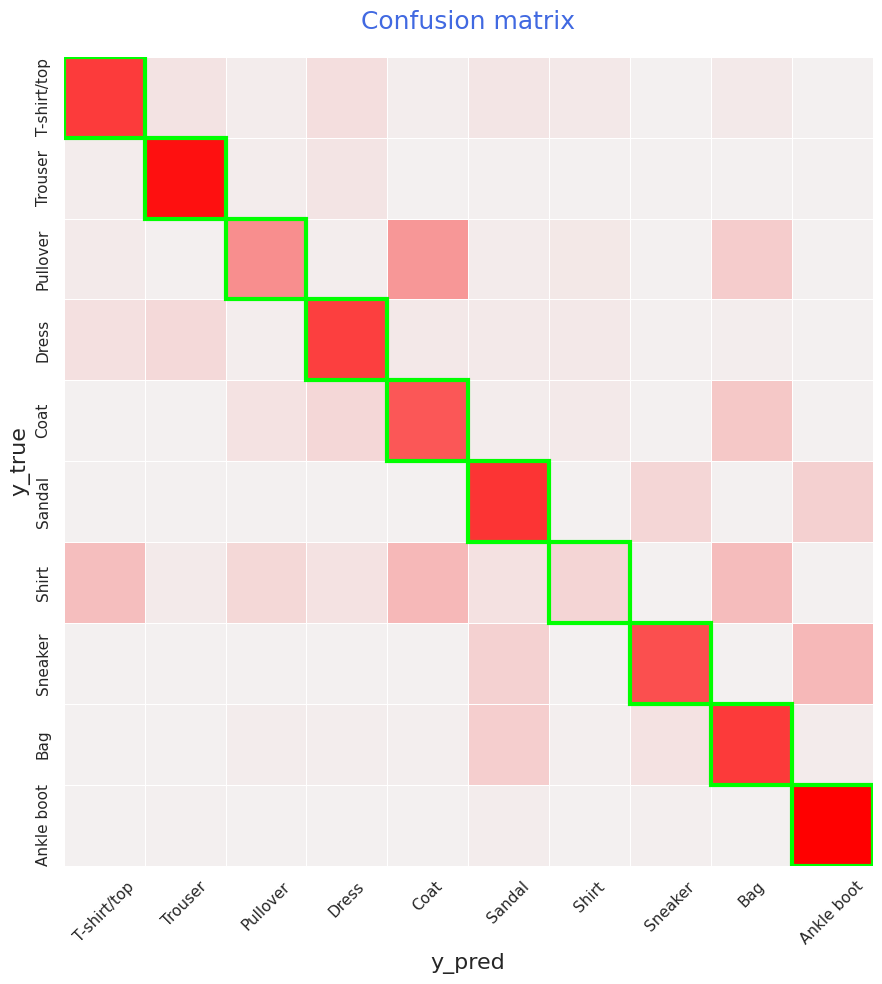

In [ ]:


run = wandb.init(project="DA6401_Q7", reinit=True)
plot = plot_confusion_matrix(
    X_train=X_train,
    y_train=y_train,
    num_hidden_layers=5,  # Specify the number of hidden layers
    hidden_layer_sizes=[128, 64, 32],  # Specify possible sizes per hidden layer
    activation_fns=["tanh", "sigmoid", "tanh"],  # Specify possible activations
    optimizer="adam",
    batch_size=10000,
    learning_rate=0.01,
    epochs=5,
    weight_init="Xavier_U",
    loss_fn="ce",
    reg_type="L2",
    weight_decay=0.0005,
    val_ratio=0.1,
    method="Xavier_U",
    beta=0.9,
    beta2=0.999,
    X_test=X_test,
    y_test=y_test
)
plot.confusion_matrix()
run.finish()

**--------------------------------------------------------------------------------------------------------------------------------------------------------------**


# ✅ Question 8 :
## In all the models above you would have used cross entropy loss. Now compare the cross entropy loss with the squared error loss. I would again like to see some automatically generated plots or your own plots to convince me whether one is better than the other.

**--------------------------------------------------------------------------------------------------------------------------------------------------------------**

**"Cross-entropy" and "Square-loss" is added in sweep for both loss comparision**

In [ ]:
# Add a new parameter for loss function to the sweep config
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'num_hidden_layers': {'values': [3, 4, 5]},
        'hidden_layer_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [0.001, 0.0001]},
        'optimizer': {'values': ["sgd", 'momentum', 'nag', 'rmsp', 'adam']},
        'batch_size': {'values': [1000, 2000, 5000]},
        'weight_init': {'values': ['Random', 'Xavier_U']},
        'activation_fn': {'values': ['sigmoid', 'tanh', 'relu']},
        'loss_fn': {'values': ['ce', 'se']}  # <-- Added for comparison
    }
}

# Training function using the chosen loss function
def sweep_train():
    wandb.init()
    config = wandb.config

    hidden_sizes = [config.hidden_layer_size] * config.num_hidden_layers
    activations = [config.activation_fn] * config.num_hidden_layers

    loss_name = "ce" if config.loss_fn == "ce" else "se"
    wandb.run.name = f"{loss_name}_hl_{config.num_hidden_layers}_bs_{config.batch_size}_ac_{config.activation_fn}"

    trainer = NNTrainer(
        X_train=X_train,
        y_train=y_train,
        num_hidden_layers=config.num_hidden_layers,
        hidden_layer_sizes=hidden_sizes,
        activation_fns=activations,
        optimizer=config.optimizer,
        batch_size=config.batch_size,
        learning_rate=config.learning_rate,
        epochs=config.epochs,
        weight_init=config.weight_init,
        loss_fn=loss_name,
        reg_type="L2",
        weight_decay=config.weight_decay,
        val_ratio=0.1,
        method=config.weight_init,
        beta=0.9,
        beta2=0.999,
        X_test=X_test,
        y_test=y_test
    )

    train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = trainer.train()

    wandb.log({
        'train_loss': train_loss,
        'train_accuracy': train_acc,
        'val_loss': val_loss,
        'val_accuracy': val_acc,
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'loss_fn': config.loss_fn
    })

# Launch sweep
sweep_id = wandb.sweep(sweep_config, project="DL_Assignment_8")
wandb.agent(sweep_id, function=sweep_train, count=200)


In [ ]:
wandb.finish()

**Below function will plot the comparesion between "Squared_error" and "Cross_entropy" and it can be seen observed in wandb also**

In [ ]:
import wandb
api = wandb.Api()
runs = api.runs("DL_Assignment_8")

# Example: comparing final validation accuracy
data = []
for run in runs:
    config = run.config
    val_acc = run.summary.get("val_accuracy")
    loss_fn = config.get("loss_fn")
    data.append((loss_fn, val_acc))

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(data, columns=["Loss Function", "Validation Accuracy"])
sns.boxplot(x="Loss Function", y="Validation Accuracy", data=df)
plt.title("Cross Entropy vs Squared Error on Validation Accuracy")
plt.show()


**--------------------------------------------------------------------------------------------------------------------------------------------------------------**


# ✅ Question 9 :
## Paste a link to your github code for this assignment

## We will check for coding style, clarity in using functions and a README file with clear instructions on training and evaluating the model (the 10 marks will be based on this)

## We will also run a plagiarism check to ensure that the code is not copied (0 marks in the assignment if we find that the code is plagiarized)

## We will also check if the training and test data has been split properly and randomly. You will get 0 marks on the assignment if we find any cheating (e.g., adding test data to training data) to get higher accuracy

**--------------------------------------------------------------------------------------------------------------------------------------------------------------**

**All my observations are in README.md file in Github. The link of my Github account is given below**

## Github Link : https://github.com/indramandal85/DA6401_Assignment_1.git

**--------------------------------------------------------------------------------------------------------------------------------------------------------------**

# ✅ Question 10 :
## Based on your learnings above, give me 3 recommendations for what would work for the MNIST dataset (not Fashion-MNIST). Just to be clear, I am asking you to take your learnings based on extensive experimentation with one dataset and see if these learnings help on another dataset. If I give you a budget of running only 3 hyperparameter configurations as opposed to the large number of experiments you have run above then which 3 would you use and why. Report the accuracies that you obtain using these 3 configurations.

**--------------------------------------------------------------------------------------------------------------------------------------------------------------**

**In README.md**